In [7]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import sys
sys.path.append("lmshap")
from genaishap import GenAIExplainer

# Load test dataset and compute correctness flags
df_test_dataset = pd.read_json('./test-dataset.json', orient='records')
df_test_dataset['severity_correct'] = (df_test_dataset['severity'] == df_test_dataset['pred_severity_phi']).astype('int64')
df_test_dataset['classification_correct'] = (df_test_dataset['classification'] == df_test_dataset['pred_classification_phi']).astype('int64')

# Load feature dataset
df_features = pd.read_json('data/test-features.json', orient='records')

# Initialize GenAIExplainer
df_features_filtered = df_features.drop(columns=[
    # ,'list_of_identified_train_station_features',
    ])
genai_explainer = GenAIExplainer.from_pandas(
    df_test_dataset[['user_input', 'severity_correct', 'classification_correct']],
    df_features_filtered
)

# Perform feature engineering
genai_explainer.feature_engineering()
genai_explainer.select_top_features_as_dict(df_target=df_test_dataset, target_column='severity_correct', top_n = 100)

# Create SHAP explainers
genai_explainer.create_explainers()
print("SHAP explainers created for metrics:", genai_explainer.explainers_.keys())
for explainer in genai_explainer.explainers_.keys():
    print(f"Type of explainer for {explainer}: {type(genai_explainer.explainers_[explainer])}")
df_test_dataset_preprocessed = pd.DataFrame(genai_explainer.preprocessed_features)


severity_correct: 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]
c:\Users\micheleu\AppData\Local\miniconda3\envs\crsb\Lib\site-packages\genaishap\explainer.py:282: UserWarning: The best estimator for metric severity_correct is producing results that differs significantly with respect to the original metrics. This could lead to produce misleading explanations. Please change the features used to train the black-box model.
  warnings.warn(
c:\Users\micheleu\AppData\Local\miniconda3\envs\crsb\Lib\site-packages\genaishap\explainer.py:299: UserWarning: There are 18 estimated values in the metric severity_correct far from the original values. The following is the list of indexes [5, 12, 14, 22, 29, 32, 38, 44, 46, 50, 51, 59, 69, 77, 78, 80, 86, 93].
  warnings.warn(
classification_correct: 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]
c:\Users\micheleu\AppData\Local\miniconda3\envs\crsb\Lib\site-packages\genaishap\explainer.py:282: UserWarning: The best estimator for metric classification_cor

SHAP explainers created for metrics: dict_keys(['severity_correct', 'classification_correct'])
Type of explainer for severity_correct: <class 'shap.explainers._tree.TreeExplainer'>
Type of explainer for classification_correct: <class 'shap.explainers._tree.TreeExplainer'>


## SHAP Summary Plot for Metric: severity_correct

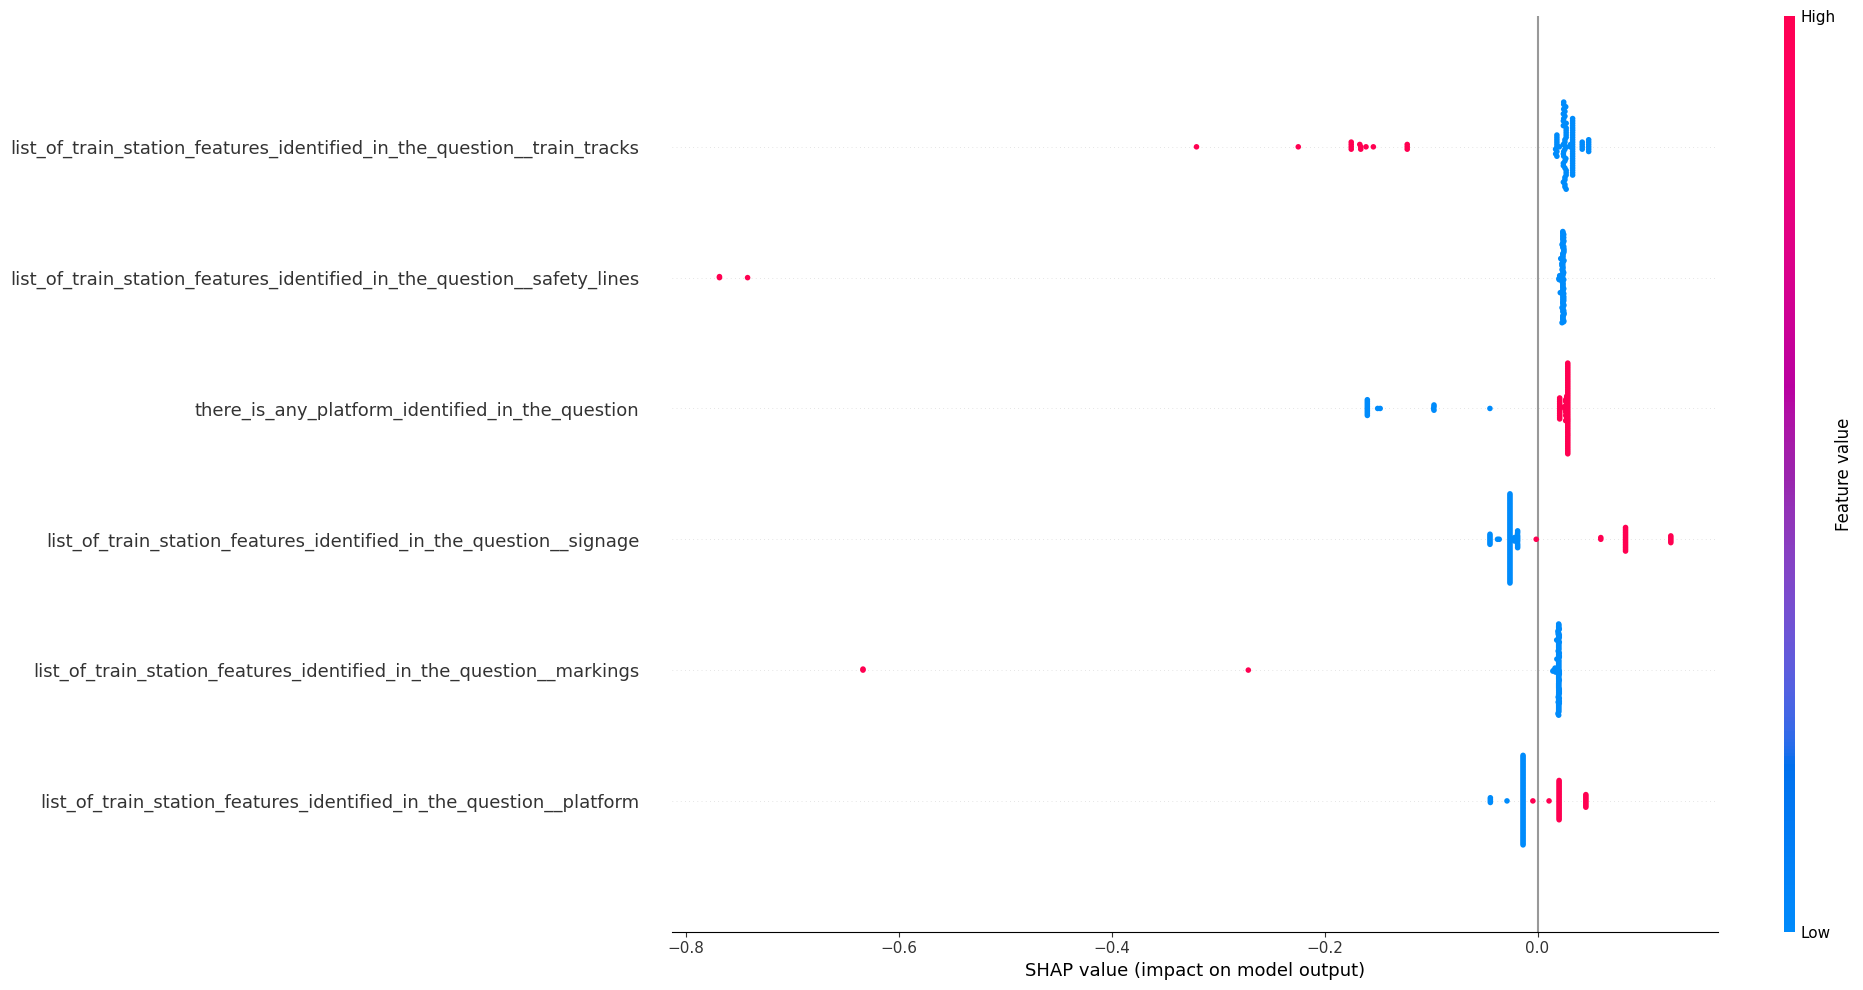

In [8]:
# metric = 'severity_correct'
# metric = 'classification_correct'
metrics = [
    'severity_correct', 
    # 'classification_correct',
    ]
X = df_test_dataset_preprocessed
for metric in metrics:
    display(Markdown(f"## SHAP Summary Plot for Metric: {metric}"))
    metric_explainer = genai_explainer.explainers_[metric]
    shap_values = metric_explainer(X)
    shap.summary_plot(shap_values, X, plot_size=(20,10), max_display=6)


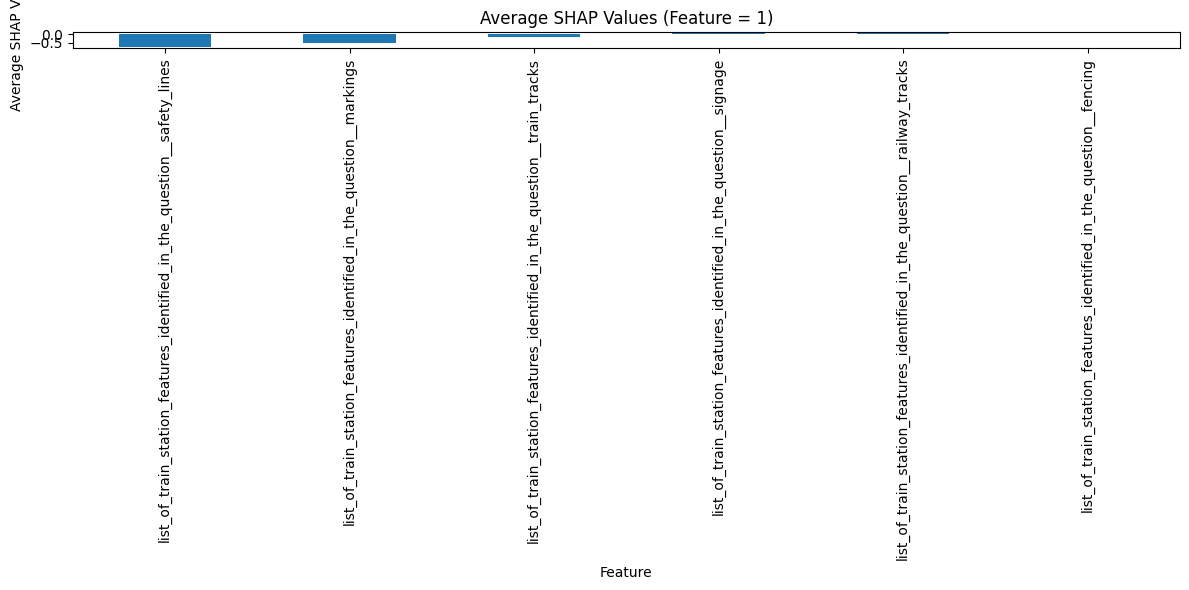

In [9]:
import pandas as pd
import shap
import matplotlib.pyplot as plt

def shap_values_to_dataframe(shap_values, feature_names=None):
    """Convert SHAP values to a pandas DataFrame."""
    if isinstance(shap_values, shap._explanation.Explanation):
        return pd.DataFrame(shap_values.values, columns=feature_names or shap_values.feature_names)
    return pd.DataFrame(shap_values, columns=feature_names)

def filter_features_by_min_instances(X, min_instances=10):
    """Return list of features with at least `min_instances` of both 0 and 1."""
    return [
        col for col in X.columns
        if (X[col] == 0).sum() >= min_instances and (X[col] == 1).sum() >= min_instances
    ]

def compute_avg_shap_when_feature_is_one(df_shap, X, valid_features):
    """Compute average SHAP values for features where X == 1."""
    avg_shap = {
        col: df_shap.loc[X[col] == 1, col].mean()
        for col in valid_features
    }
    return pd.Series(avg_shap).reindex(
        pd.Series(avg_shap).abs().sort_values(ascending=False).index
    )

def plot_top_shap_values(sorted_avg_shap, top_n=6, output_path=None):
    """Plot top N SHAP values and optionally save to file."""
    ax = sorted_avg_shap.head(top_n).plot(
        kind='bar', figsize=(12, 6), title='Average SHAP Values (Feature = 1)'
    )
    ax.set_ylabel('Average SHAP Value')
    ax.set_xlabel('Feature')
    plt.tight_layout()
    if output_path:
        plt.savefig(output_path)
    plt.show()

# Example usage
df_shap = shap_values_to_dataframe(shap_values)
valid_features = filter_features_by_min_instances(X, min_instances=3)
sorted_avg_shap = compute_avg_shap_when_feature_is_one(df_shap, X, valid_features)
sorted_avg_shap.to_csv('data/average_shap_values.csv', index=True, header=True)
plot_top_shap_values(sorted_avg_shap, top_n=6)


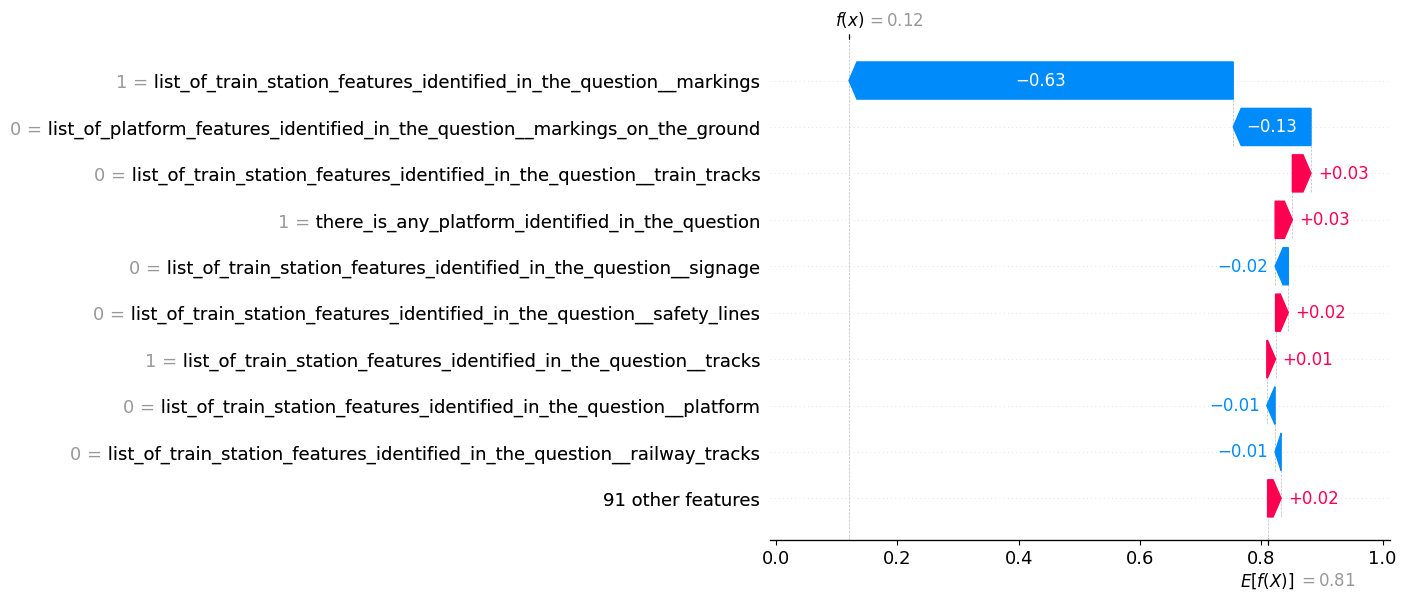

In [10]:
# df_test_dataset[['severity_correct']] == 0
shap.waterfall_plot(shap_values[2])

In [11]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from genaishap import GenAIExplainer

# Load datasets
df_test_dataset = pd.read_json('./test-dataset.json', orient='records')
df_features = pd.read_json('data/test-features.json', orient='records')

# Add correctness flags
df_test_dataset['severity_correct'] = (df_test_dataset['severity'] == df_test_dataset['pred_severity_phi']).astype('int64')
df_test_dataset['classification_correct'] = (df_test_dataset['classification'] == df_test_dataset['pred_classification_phi']).astype('int64')

# Initialise explainer
genai_explainer = GenAIExplainer.from_pandas(
    df_test_dataset[['user_input', 'severity_correct', 'classification_correct']],
    df_features
)
genai_explainer.feature_engineering()
genai_explainer.create_explainers()

# Prepare features
X = pd.DataFrame(genai_explainer.preprocessed_features)



severity_correct: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]
c:\Users\micheleu\AppData\Local\miniconda3\envs\crsb\Lib\site-packages\genaishap\explainer.py:299: UserWarning: There are 22 estimated values in the metric severity_correct far from the original values. The following is the list of indexes [2, 7, 10, 12, 14, 15, 18, 20, 26, 32, 38, 44, 46, 50, 55, 59, 67, 69, 70, 78, 80, 93].
  warnings.warn(
classification_correct: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]
c:\Users\micheleu\AppData\Local\miniconda3\envs\crsb\Lib\site-packages\genaishap\explainer.py:299: UserWarning: There are 13 estimated values in the metric classification_correct far from the original values. The following is the list of indexes [7, 14, 15, 18, 28, 32, 44, 46, 59, 77, 78, 80, 93].
  warnings.warn(
Metric loop: 100%|██████████| 2/2 [00:07<00:00,  3.56s/it]


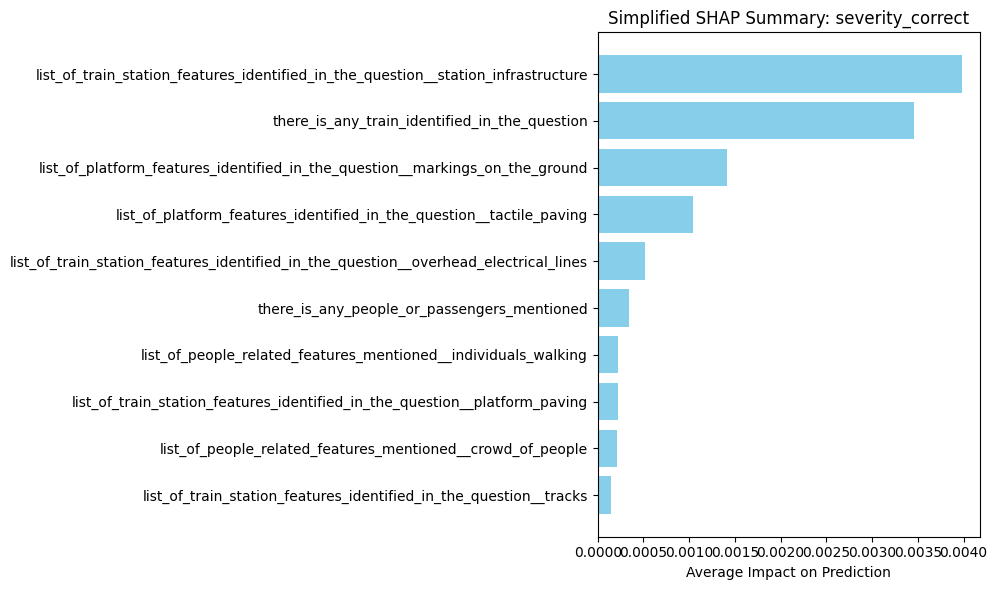

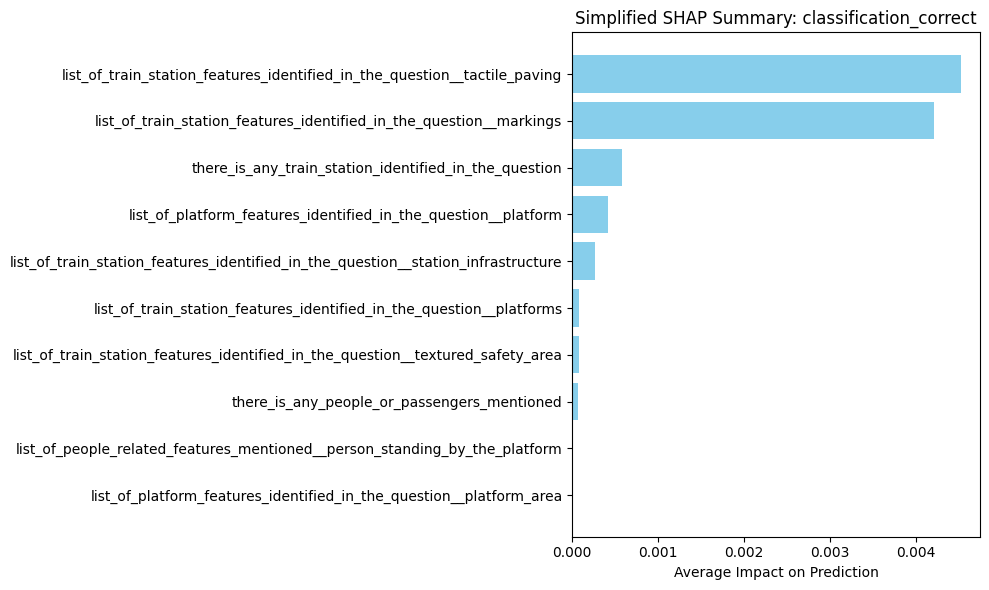

In [12]:

# Generate simplified SHAP bar plots
for metric in ['severity_correct', 'classification_correct']:
    explainer = genai_explainer.explainers_[metric]
    shap_values = explainer(X)

    mean_shap = pd.DataFrame({
        'feature': X.columns,
        'mean_shap': (shap_values.values).mean(axis=0)
    }).sort_values(by='mean_shap', ascending=False).head(10)

    plt.figure(figsize=(10, 6))
    plt.barh(mean_shap['feature'], mean_shap['mean_shap'], color='skyblue')
    plt.xlabel('Average Impact on Prediction')
    plt.title(f'Simplified SHAP Summary: {metric}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

